In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from fine_structure.language_models.models import rnn_lm
from fine_structure.language_models.preprocess import preprocess
from fine_structure.language_models.eval import postprocess, get_char_counts, get_char_counts_by_position, generate_sequence, perplexity

/home/aklenitskiy/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
DATA_PATH = 'tox21/tox21.csv'

config = {}
config['max_len'] = 100
config['model_params'] = {'rnn_type': 'GRU',
                          'embedding_size': None,
                          'num_rnn_layers': 2,
                          'num_cells': 128,
                          'spatial_dropout': 0,
                          'optimizer': 'Adam',
                          'optimizer_params': {'lr': 1e-2}
                         }
config['train_params'] = {'batch_size': 32,
                          'epochs': 10,
                          'validation_split': 0.1}

### prepare data

In [3]:
df = pd.read_csv(os.path.join(os.environ['FINE_STRUCTURE_DATA'], DATA_PATH))
print(df.shape)
df.head()

(7831, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [4]:
text = df.smiles.tolist()

In [5]:
if config['model_params']['embedding_size'] is None:
    X, y, tokenizer = preprocess(text, maxlen=config['max_len'], onehot=True)
else:
    X, y, tokenizer = preprocess(text, maxlen=config['max_len'])

print('vocab size: ', tokenizer.vocab_size)
print(f'X shape: {X.shape}, y shape: {y.shape}')

vocab size:  59
X shape: (7831, 100, 59), y shape: (7831, 100, 59)


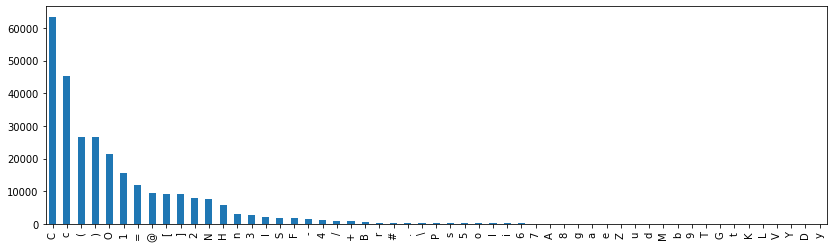

In [6]:
# char counts
pd.Series(tokenizer.token_counts).sort_values(ascending=False).plot(kind='bar', figsize=(14, 4))

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
print(Xtrain.shape, Xtest.shape)

(5481, 100, 59) (2350, 100, 59)


### train model

In [8]:
model = rnn_lm(input_len=ytrain.shape[1], vocab_size=ytrain.shape[2],
               **config['model_params'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 59)]         0         
_________________________________________________________________
gru (GRU)                    (None, 100, 128)          72576     
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 128)          99072     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 59)           7611      
Total params: 179,259
Trainable params: 179,259
Non-trainable params: 0
_________________________________________________________________


In [9]:
if config['model_params']['embedding_size'] is None:
    hist = model.fit(Xtrain, ytrain, **config['train_params'])
else:
    hist = model.fit(Xtrain, ytrain, **config['train_params'])
    
pred = model.predict(Xtest)

Train on 4932 samples, validate on 549 samples
Epoch 1/10
4932/4932 [==============================] - 15s 3ms/sample - loss: 0.6171 - accuracy: 0.8225 - val_loss: 0.4053 - val_accuracy: 0.8675
Epoch 2/10
4932/4932 [==============================] - 13s 3ms/sample - loss: 0.3725 - accuracy: 0.8788 - val_loss: 0.3532 - val_accuracy: 0.8836
Epoch 3/10
4932/4932 [==============================] - 13s 3ms/sample - loss: 0.3353 - accuracy: 0.8889 - val_loss: 0.3307 - val_accuracy: 0.8904
Epoch 4/10
4932/4932 [==============================] - 14s 3ms/sample - loss: 0.3116 - accuracy: 0.8964 - val_loss: 0.3175 - val_accuracy: 0.8946
Epoch 5/10
4932/4932 [==============================] - 17s 4ms/sample - loss: 0.2968 - accuracy: 0.9007 - val_loss: 0.3127 - val_accuracy: 0.8960
Epoch 6/10
4932/4932 [==============================] - 15s 3ms/sample - loss: 0.2855 - accuracy: 0.9042 - val_loss: 0.3034 - val_accuracy: 0.8993
Epoch 7/10
4932/4932 [==============================] - 14s 3ms/sample 

### analyze

accuracy

In [19]:
pred_idx, ytest_idx, errors = postprocess(pred, ytest)

print('Mean accuracy', 1-np.nanmean(errors))

Mean accuracy 0.7251285864782797


In [20]:
%%time
perplexity(ytest, pred)

CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 1.74 s


2.4655612901170976

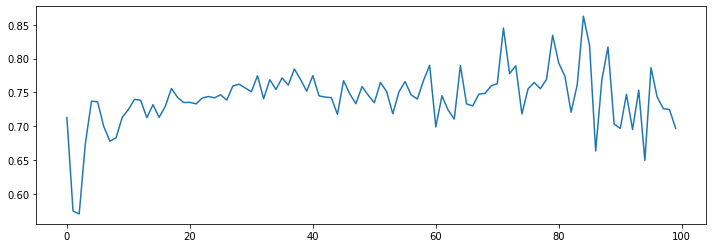

In [21]:
# mean accuracy  by position
plt.figure(figsize=(12,4))
plt.plot(1 - np.nanmean(errors, axis=0))

char counts

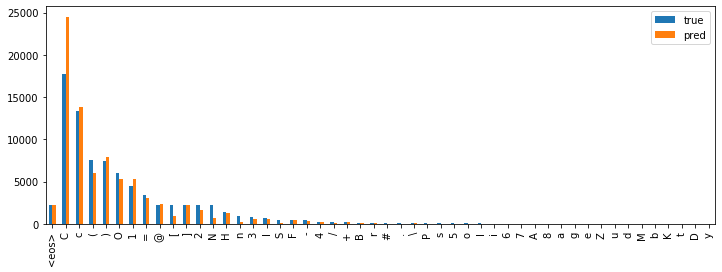

In [22]:
pred_char_counts = get_char_counts(pred_idx, tokenizer.index2token)
ytest_char_counts = get_char_counts(ytest_idx, tokenizer.index2token)

char_counts = ytest_char_counts.rename('true').to_frame().join(
    pred_char_counts.rename('pred')).fillna(0).astype(int)

char_counts.plot(kind='bar', figsize=(12, 4))

char counts by posiiton

In [23]:
ytest_char_counts_by_position = get_char_counts_by_position(ytest_idx, tokenizer.index2token)
pred_char_counts_by_position = get_char_counts_by_position(pred_idx, tokenizer.index2token)
pred_char_counts_by_position = pred_char_counts_by_position.reindex(index=ytest_char_counts_by_position.index).fillna(0)

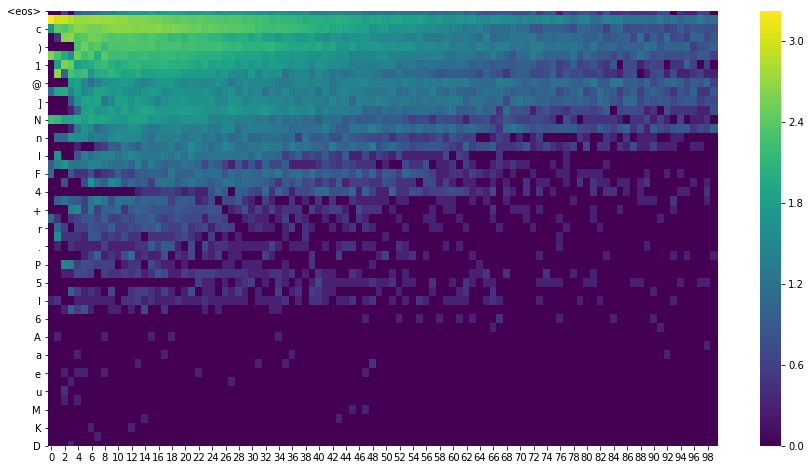

In [24]:
plt.figure(figsize=(15, 8))
sns.heatmap(np.log10(ytest_char_counts_by_position + 1), cmap='viridis')

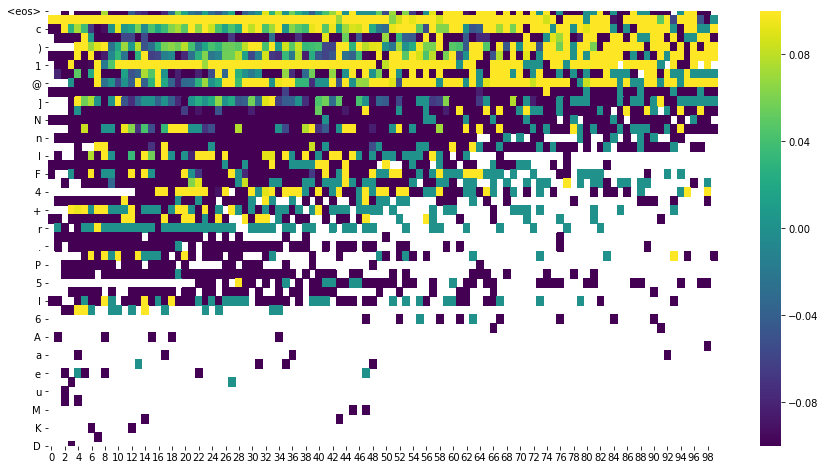

In [25]:
plt.figure(figsize=(15, 8))
sns.heatmap(pred_char_counts_by_position/ytest_char_counts_by_position - 1, cmap='viridis')

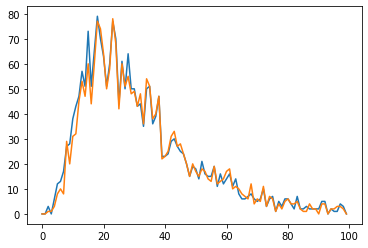

In [26]:
ytest_char_counts_by_position.loc['<eos>'].plot()
pred_char_counts_by_position.loc['<eos>'].plot()

### generation

In [36]:
seed_sequence = 'COc'
temperature = 1
length = 30
num_attempts = 10

for i in range(num_attempts):
    
    if config['model_params']['embedding_size'] is None:
        seq = generate_sequence(model, seed_sequence, tokenizer,
                                length=length, maxlen=config['max_len'],
                                onehot=True, temperature=temperature)
    else:
        seq = generate_sequence(model, seed_sequence, tokenizer,
                                length=length, maxlen=config['max_len'],
                                onehot=False, temperature=temperature)
    print(seq)

COc1C[C@@H]1CC[C@H](CN)C(=O)O<eos>
COc2c(-c3c(S(=O)(=O)O)ccc3cccccc3
COcc1c([O-])c(Br)c(-c2ccccc2)n1<eos>
COc1cc2c(cc1)-c1cccc1-c1cc2cc3ccc
COc1c2ccccc2c1<eos>
COcc1cc(S2)cc1C#N<eos>
COc1C(=O)NCCCN1CCN1CCC[C@@H]2CCC(
COc1c(O)c2c(sc1=N/O=C(/C=C/CC/C=C
COc1cccc2oc3ccccn13<eos>
COc1ccccc1OCC(CO)c1cccc2c1[C@@H]1
